In [1]:
import numpy as np
from numpy.random import randn
from numpy.linalg import norm
from scipy.linalg import pinv, qr
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
plt.rcParams['font.size'] = 18

np.random.seed(42)

In [2]:
# It is difficult to get qr to work at all with Φ as it has a rank only 14 
# matlab backslash is giving rank warnings but then doing something unknown
# the behaviour with averaging is unstable, depending on the random seed
# The matlab behaviour isn't reproducible in octave either.
def lstsq_qr(A, b):
    """Try and simulate matlab backslash using a qr decomposition"""
    Q, R = qr(A, mode='economic')
    return pinv(R) @ (Q.T @ b)

In [3]:
# Parabola with 100 data points
L = 4
n = 100
x = np.linspace(0, L, n)

# Polynomial degree (0..20)
M = 21
Φ = x[:, np.newaxis] ** np.arange(M)

# Noise
σ = 0.2

trial_lengths = [2, 10, 100]

Ams = {'pinv': [], 'backslash': [], 'lasso': []}

for ntrials in trial_lengths:
    a_pinv, a_backslash, a_lasso = [], [], []
    for _ in range(ntrials):
        f = x**2 + σ * randn(n)
        a_pinv += [pinv(Φ) @ f]
        a_backslash += [lstsq_qr(Φ, f)]
        a_lasso += [
            Lasso(alpha=0.1, max_iter=10000, normalize=True).fit(Φ, f).coef_
        ]

    Ams['pinv'] += [np.mean(a_pinv, axis=0)]
    Ams['backslash'] += [np.mean(a_backslash, axis=0)]
    Ams['lasso'] += [np.mean(a_lasso, axis=0)]

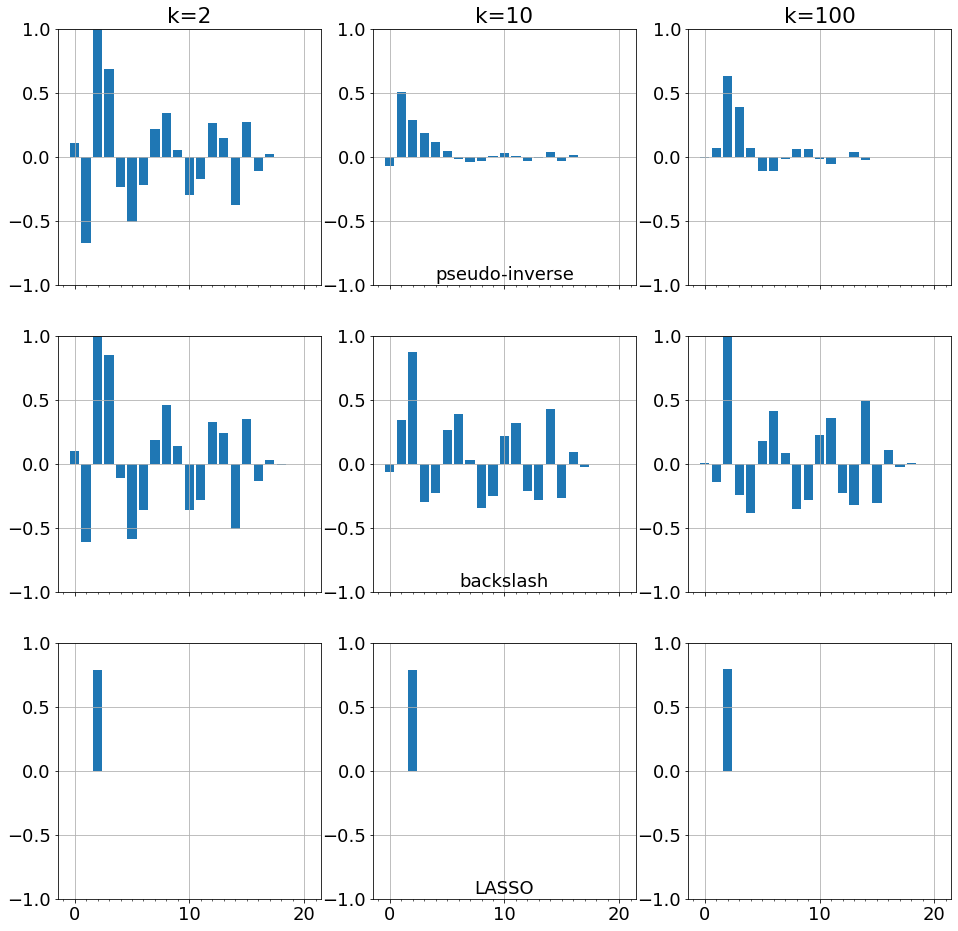

In [4]:
# Figure 4.18
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(16, 16))
for i, ntrials in enumerate(trial_lengths):
    axs[0, i].bar(range(M), Ams['pinv'][i])
    axs[0, i].set_title(f'k={ntrials}')
    axs[1, i].bar(range(M), Ams['backslash'][i])
    axs[2, i].bar(range(M), Ams['lasso'][i])

for ax in axs.flat:
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_ylim([-1, 1])
    ax.grid(True)

for ax, label in zip(axs[:, 1], ['pseudo-inverse', 'backslash', 'LASSO']):
    ax.text(0.5, 0.02, label, horizontalalignment='center', transform=ax.transAxes)

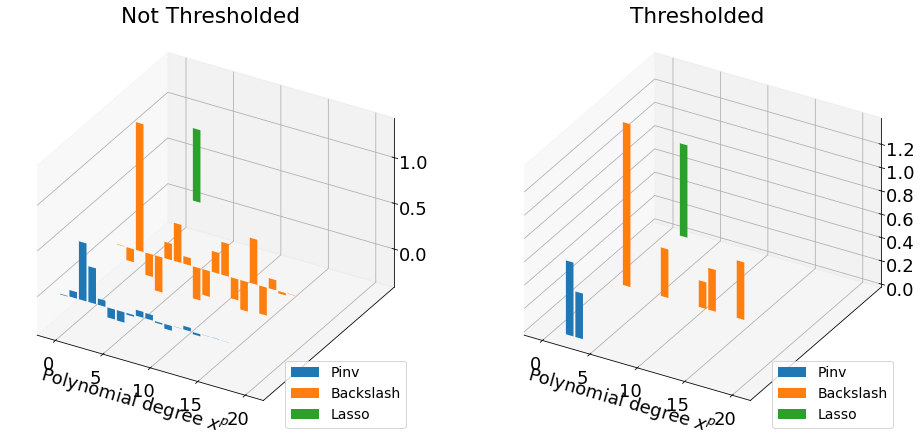

In [5]:
# Figure 1.19 a-b
threshold = 0.2
Am_100 = {k: v[-1] for (k, v) in Ams.items()}
Am_100_thresh = {k: v * (v > threshold) for (k, v) in Am_100.items()}

fig, axs = plt.subplots(
    1, 2,
    subplot_kw=dict(projection='3d', proj_type='ortho'),
    sharex=True, sharey=True, figsize=(16, 8)
)

for i, key in enumerate(Am_100):
    axs[0].bar(
        np.arange(M),
        Am_100[key],
        zs=i, zdir='y',
        label=f'{key.capitalize()}'
    )
axs[0].set_title('Not Thresholded')
axs[0].legend(loc='lower right', fontsize=14)
axs[0].grid(True)
axs[0].set_xlabel(r'Polynomial degree $x^p$')
axs[0].set_yticks([])
axs[0].set_yticklabels([])

for i, key in enumerate(Am_100_thresh):
    axs[1].bar(
        np.arange(M),
        Am_100_thresh[key],
        zs=i, zdir='y',
        label=f'{key.capitalize()}'
    )
axs[1].set_title('Thresholded')
axs[1].legend(loc='lower right', fontsize=14)
axs[1].grid(True)
axs[1].set_xlabel(r'Polynomial degree $x^p$')
axs[1].set_yticks([])
axs[1].set_yticklabels([]);

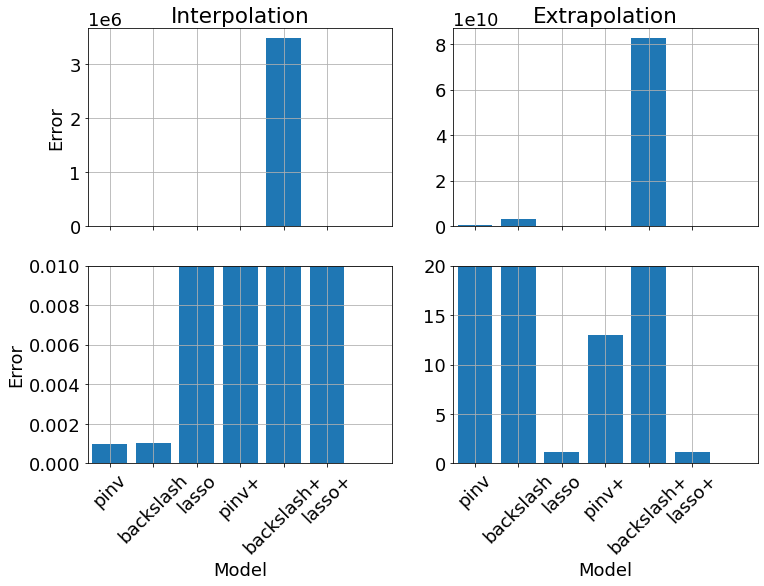

In [6]:
# Figure 1.19 c-f
n = 200
L = 8
x = np.linspace(0, L, n)
x1 = x[:100]    # Train
x2 = x[100:200] # Test
n1 = len(x1)
n2 = len(x2)

ftrain = x1**2 # Train parabola x = [0,4]
ftest = x2**2  # Test parabola x = [4,8]

Φ_i = x1[:, np.newaxis] ** np.arange(M)[np.newaxis, :] # interpolation
Φ_e = x2[:, np.newaxis] ** np.arange(M)[np.newaxis, :] # extrapolation

E_ni = [
    norm(ftrain - Φ_i @ a) / norm(ftrain)
    for a in Am_100.values()
]
E_ni_thresh = [
    norm(ftrain - Φ_i @ a) / norm(ftrain)
    for a in Am_100_thresh.values()
]
E_ne = [
    norm(ftest - Φ_e @ a) / norm(ftrain)
    for a in Am_100.values()
]
E_ne_thresh = [
    norm(ftest - Φ_e @ a) / norm(ftrain)
    for a in Am_100_thresh.values()
]

models = list(Am_100.keys()) + [f'{k}+' for k in Am_100]
nmodels = len(models)
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
axs[0, 0].bar(range(nmodels), E_ni + E_ni_thresh, tick_label=models)
axs[0, 0].set_title('Interpolation')
axs[0, 0].set_ylabel('Error')

axs[0, 1].bar(range(nmodels), E_ne + E_ne_thresh, tick_label=models)
axs[0, 1].set_title('Extrapolation')

axs[0, 0].set_xticklabels(models, rotation=45)
axs[0, 1].set_xticklabels(models, rotation=45)

axs[1, 0].bar(range(nmodels), E_ni + E_ni_thresh, tick_label=models)
axs[1, 1].bar(range(nmodels), E_ne + E_ne_thresh, tick_label=models)
axs[1, 0].set_xlim(-0.5, 6.5)
axs[1, 0].set_ylim(0, 0.01)
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Error')

axs[1, 1].set_xlim(-0.5, 6.5)
axs[1, 1].set_ylim(0, 20)              
axs[1, 1].set_xlabel('Model')
axs[1, 0].set_xticklabels(models, rotation=45)
axs[1, 1].set_xticklabels(models, rotation=45)

for ax in axs.flat:
    ax.grid(True)